# Проект: Генерация семантических эмбеддингов карт по масти и рангу с помощью VAE

## 📌 Пересмотренная задача
**Цель**: Создание латентных представлений карт на основе их характеристик (масть и ранг) с использованием вариационного автоэнкодера.
**Особенности**:
- Входные данные: Категориальные признаки (масть и ранг) вместо изображений
- Выход: Низкоразмерные эмбеддинги, сохраняющие семантические отношения между картами

## 1. Импорт библиотек и настройка среды

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
seed = 42
torch.manual_seed(seed)

## 2. Подготовка структурированного датасета

In [108]:
suit_data = torch.tensor([0, 1, 2, 3] * 13)  # Все масти по порядку
rank_data = torch.tensor(list(range(13)) * 4)  # Все ранги по порядку
dataset = TensorDataset(suit_data, rank_data)

## 🧠 Архитектура автоэнкодера для генерации эмбеддингов

**Описание**:
Реализация стандартного автоэнкодера для преобразования пары (масть, ранг) в семантические эмбеддинги. Модель состоит из:
- **Энкодера**: Преобразует категориальные признаки в плотное векторное представление
- **Декодера**: Восстанавливает исходные характеристики из эмбеддинга
- **Бутылочного горлышка**: Низкоразмерное представление карты (эмбеддинг)

**Ключевые особенности**:
- Отдельные эмбеддинг-слои для масти и ранга
- Линейные слои с активацией ReLU
- Размерность эмбеддинга: 4 измерений
- Выходы декодера: логиты для масти (4 класса) и ранга (13 классов)

In [109]:
class CardAutoencoder(nn.Module):
    def __init__(self, embedding_dim=4):
        super(CardAutoencoder, self).__init__()
        self.embedding_dim = embedding_dim

        # Эмбеддинги для входных признаков
        self.suit_embedding = nn.Embedding(4, 4)    # 4 масти → 4D
        self.rank_embedding = nn.Embedding(13, 13)   # 13 рангов → 8D

        # Энкодер
        self.encoder = nn.Sequential(
            nn.Linear(17, 32),  # 4 (масть) + 8 (ранг) = 12 входов
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, embedding_dim)  # Бутылочное горлышко
        )

        # Декодер
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        # Выходные слои
        self.suit_decoder = nn.Linear(32, 4)   # Восстановление масти
        self.rank_decoder = nn.Linear(32, 13)  # Восстановление ранга

    def forward(self, suit, rank):
        # Входные эмбеддинги
        suit_emb = self.suit_embedding(suit)
        rank_emb = self.rank_embedding(rank)
        x = torch.cat((suit_emb, rank_emb), dim=1)

        # Кодирование
        embedding = self.encoder(x)

        embedding = F.normalize(embedding, p=2, dim=1)

        # Декодирование
        decoded = self.decoder(embedding)

        # Восстановление характеристик
        suit_logits = self.suit_decoder(decoded)
        rank_logits = self.rank_decoder(decoded)

        return suit_logits, rank_logits, embedding

    def get_embedding(self, suit, rank):
        # Возвращает только эмбеддинг без декодирования
        suit_emb = self.suit_embedding(suit)
        rank_emb = self.rank_embedding(rank)
        x = torch.cat((suit_emb, rank_emb), dim=1)
        embedding = self.encoder(x)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding


## 🧠 Определение функции потерь и оптимизатора

**Цель:**
Реализовать механизм обучения автоэнкодера, включая:

- Функцию потерь для оценки качества реконструкции масти и ранга

- Оптимизатор для обновления параметров модели

- Метрики для мониторинга процесса обучения

**Ключевые компоненты:**

- Функция потерь: Комбинация двух кросс-энтропийных потерь (для масти и ранга)

- Оптимизатор: SGD с настраиваемой скоростью обучения

- Метрики: Точность предсказания масти/ранга

In [110]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        anchor: Эмбеддинг исходной карты [batch, dim]
        positive: Эмбеддинг схожей карты [batch, dim]
        negative: Эмбеддинг непохожей карты [batch, dim]
        """
        pos_dist = F.pairwise_distance(anchor, positive, 2)
        neg_dist = F.pairwise_distance(anchor, negative, 2)

        losses = F.relu(pos_dist - neg_dist + self.margin)
        return losses.mean()

def generate_triplets(suit_batch, rank_batch, n=1):
    anchors = []
    positives = []
    negatives = []

    for i in range(len(suit_batch)):
        anchor_suit = suit_batch[i]
        anchor_rank = rank_batch[i]

        # 1. Positive candidates: два типа схожести
        # Тип A: Та же масть, соседний ранг (±n)
        neighbor_mask = (suit_batch == anchor_suit) & \
                        (torch.abs(rank_batch - anchor_rank) <= n) & \
                        (rank_batch != anchor_rank)

        # Тип B: Тот же ранг, другая масть
        same_rank_mask = (rank_batch == anchor_rank) & \
                         (suit_batch != anchor_suit)

        positive_candidates = torch.where(neighbor_mask | same_rank_mask)[0]
        # 2. Negative candidates: карты, значительно отличающиеся по обоим признакам
        # - Другая масть И ранг отличается больше чем на n
        negative_candidates = torch.where(
            (suit_batch != anchor_suit) &
            (torch.abs(rank_batch - anchor_rank) > n)
        )[0]

        # 3. Проверяем наличие кандидатов
        if len(positive_candidates) == 0 or len(negative_candidates) == 0:
            # Пропускаем только если совсем нет вариантов
            continue

        # 4. Выбираем случайные примеры из кандидатов
        pos_idx = positive_candidates[torch.randint(0, len(positive_candidates), (1,))]
        neg_idx = negative_candidates[torch.randint(0, len(negative_candidates), (1,))]

        anchors.append(i)
        positives.append(pos_idx.item())
        negatives.append(neg_idx.item())

    return anchors, positives, negatives

def combined_loss(suit_logits, rank_logits, suit_true, rank_true,
                 anchor_emb, positive_emb, negative_emb,
                 triplet_weight=0.5, margin=0.5):
    # Reconstruction loss
    recon_loss = F.cross_entropy(suit_logits, suit_true) + \
                 F.cross_entropy(rank_logits, rank_true)

    # Triplet loss
    triplet_loss = TripletLoss(margin=margin)(anchor_emb, positive_emb, negative_emb)

    return recon_loss + triplet_weight * triplet_loss

def composite_loss(suit_logits, rank_logits, suit_true, rank_true):
    """
    Вычисляет комбинированную потерю:
    - Кросс-энтропия для масти
    - Кросс-энтропия для ранга
    """
    suit_loss = F.cross_entropy(suit_logits, suit_true)
    rank_loss = F.cross_entropy(rank_logits, rank_true)
    return suit_loss + rank_loss

def calculate_accuracy(logits, labels):
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()

In [111]:
embedding_dim = 8
model = CardAutoencoder(embedding_dim)
print(f"Параметры модели: {sum(p.numel() for p in model.parameters()):,}")
print(f"Размерность эмбеддинга: {embedding_dim}")
dataloader = DataLoader(dataset, batch_size=52, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CardAutoencoder(embedding_dim=8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20
)
num_epochs = 2000

for epoch in range(num_epochs):
    total_loss = 0.0
    suit_acc, rank_acc = 0.0, 0.0

    for batch_suit, batch_rank in dataloader:
        batch_suit, batch_rank = batch_suit.to(device), batch_rank.to(device)

        # 1. Прямой проход для реконструкции
        suit_logits, rank_logits, embeddings = model(batch_suit, batch_rank)

        # 2. Генерация триплетов
        anchors, positives, negatives = generate_triplets(batch_suit, batch_rank, n=1)

        if len(anchors) == 0:
            # Если не удалось сгенерировать триплеты, используем только reconstruction loss
            loss = F.cross_entropy(suit_logits, batch_suit) + \
                   F.cross_entropy(rank_logits, batch_rank)
        else:
            # 3. Выделяем эмбеддинги для триплетов
            anchor_emb = embeddings[anchors]
            positive_emb = embeddings[positives]
            negative_emb = embeddings[negatives]

            # 4. Расчет комбинированной потери
            loss = combined_loss(
                suit_logits, rank_logits,
                batch_suit, batch_rank,
                anchor_emb, positive_emb, negative_emb,
                triplet_weight=1.5, margin=0.5
            )

        # 5. Оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Сбор статистики
        total_loss += loss.item()
        suit_acc += calculate_accuracy(suit_logits, batch_suit).item()
        rank_acc += calculate_accuracy(rank_logits, batch_rank).item()

    # Средние значения за эпоху
    avg_loss = total_loss / len(dataloader)
    avg_suit_acc = suit_acc / len(dataloader) * 100
    avg_rank_acc = rank_acc / len(dataloader) * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Loss: {avg_loss:.4f} | "
          f"Suit Acc: {avg_suit_acc:.2f}% | "
          f"Rank Acc: {avg_rank_acc:.2f}%")

    if avg_suit_acc == 100 and avg_rank_acc == 100:
        pass

print("Обучение завершено!")

Параметры модели: 2,674
Размерность эмбеддинга: 8
Epoch [1/2000] | Loss: 4.5424 | Suit Acc: 25.00% | Rank Acc: 0.00%
Epoch [2/2000] | Loss: 4.5493 | Suit Acc: 25.00% | Rank Acc: 0.00%
Epoch [3/2000] | Loss: 4.3881 | Suit Acc: 25.00% | Rank Acc: 0.00%
Epoch [4/2000] | Loss: 4.4852 | Suit Acc: 25.00% | Rank Acc: 0.00%
Epoch [5/2000] | Loss: 4.4263 | Suit Acc: 25.00% | Rank Acc: 1.92%
Epoch [6/2000] | Loss: 4.4094 | Suit Acc: 25.00% | Rank Acc: 1.92%
Epoch [7/2000] | Loss: 4.5153 | Suit Acc: 25.00% | Rank Acc: 3.85%
Epoch [8/2000] | Loss: 4.4520 | Suit Acc: 25.00% | Rank Acc: 3.85%
Epoch [9/2000] | Loss: 4.2989 | Suit Acc: 25.00% | Rank Acc: 5.77%
Epoch [10/2000] | Loss: 4.3958 | Suit Acc: 25.00% | Rank Acc: 5.77%
Epoch [11/2000] | Loss: 4.3420 | Suit Acc: 25.00% | Rank Acc: 5.77%
Epoch [12/2000] | Loss: 4.3216 | Suit Acc: 25.00% | Rank Acc: 5.77%
Epoch [13/2000] | Loss: 4.3205 | Suit Acc: 25.00% | Rank Acc: 5.77%
Epoch [14/2000] | Loss: 4.3299 | Suit Acc: 25.00% | Rank Acc: 5.77%
Epoch [

## 📊 Визуализация латентного пространства

**Цель**:
Анализ структуры эмбеддингов, полученных автоэнкодером, для выявления семантических закономерностей в представлении карт.

**Задачи**:
1. Получить эмбеддинги для всех карт колоды
2. Спроецировать многомерные векторы в 2D-пространство
3. Визуализировать распределение карт с цветовой маркировкой по мастям
4. Проанализировать кластеризацию и семантические расстояния
5. Проверить гипотезы о близости карт одного ранга/масти


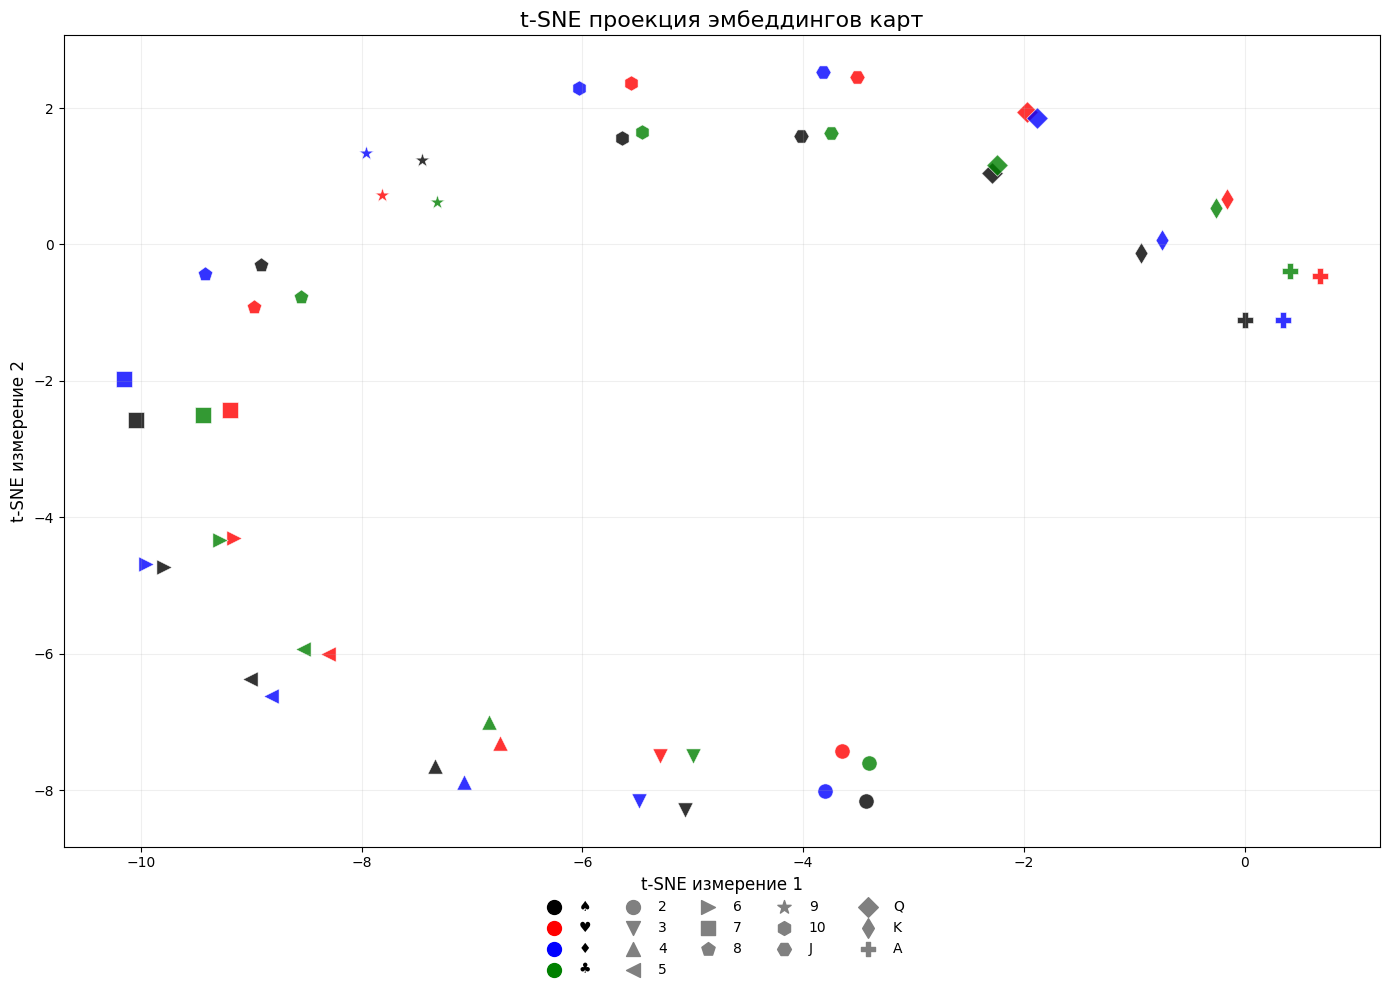

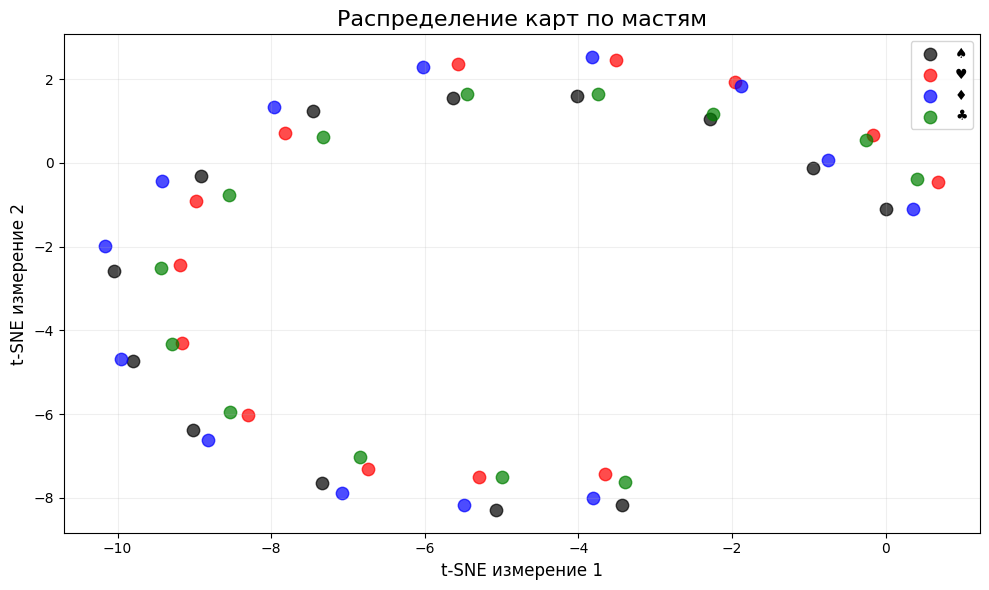

In [112]:
model.eval()
with torch.no_grad():
    embeddings = []
    for suit, rank in dataset:
        suit_tensor = torch.tensor([suit]).to(device)
        rank_tensor = torch.tensor([rank]).to(device)
        emb = model.get_embedding(suit_tensor, rank_tensor)
        embeddings.append(emb.cpu().numpy())

embeddings = np.vstack(embeddings)
if embedding_dim == 2:
   embeddings_2d = embeddings
else:
    tsne = TSNE(n_components=2, perplexity=15, random_state=seed)
    embeddings_2d = tsne.fit_transform(embeddings)
suits = suit_data.numpy()
ranks = rank_data.numpy()
colors = ['black', 'red', 'blue', 'green']
suit_colors = [colors[s] for s in suits]
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P']
rank_markers = [markers[r] for r in ranks]
plt.figure(figsize=(14, 10))

# Для каждой уникальной масти создаем отдельный scatter plot
for suit in range(4):
    # Индексы карт данной масти
    indices = np.where(suits == suit)[0]

    # Для каждой карты в масти используем свой маркер ранга
    for idx in indices:
        plt.scatter(
            embeddings_2d[idx, 0],
            embeddings_2d[idx, 1],
            c=colors[suit],
            marker=rank_markers[idx],
            s=120,
            alpha=0.8,
            edgecolors='w',
            linewidths=0.5
        )

    # Добавление названия масти в легенду
    plt.scatter([], [], c=colors[suit], label=['♠','♥','♦','♣'][suit], s=100)

# Добавление легенды для рангов
for rank in range(13):
    plt.scatter([], [], c='gray', marker=markers[rank],
                label=['2','3','4','5','6','7','8','9','10','J','Q','K','A'][rank],
                s=100)

plt.title('t-SNE проекция эмбеддингов карт', fontsize=16)
plt.xlabel('t-SNE измерение 1', fontsize=12)
plt.ylabel('t-SNE измерение 2', fontsize=12)
plt.grid(alpha=0.2)
plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.tight_layout()

# 5. Анализ кластеров
plt.figure(figsize=(10, 6))
for suit in range(4):
    indices = np.where(suits == suit)[0]
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        c=colors[suit],
        label=['♠','♥','♦','♣'][suit],
        s=80,
        alpha=0.7
    )

plt.title('Распределение карт по мастям', fontsize=16)
plt.xlabel('t-SNE измерение 1', fontsize=12)
plt.ylabel('t-SNE измерение 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 🔍 Анализ эмбеддингов и семантический поиск

**Цель**:
Использование обученного автоэнкодера для:
1. Извлечения векторных представлений карт
2. Поиска семантически близких карт по косинусному сходству
3. Визуализации отношений между картами в векторном пространстве


Карты, похожие на ♥K:
♣K: сходство = 0.9054
♦K: сходство = 0.8437
♥A: сходство = 0.7825
♥Q: сходство = 0.7311
♣A: сходство = 0.7178


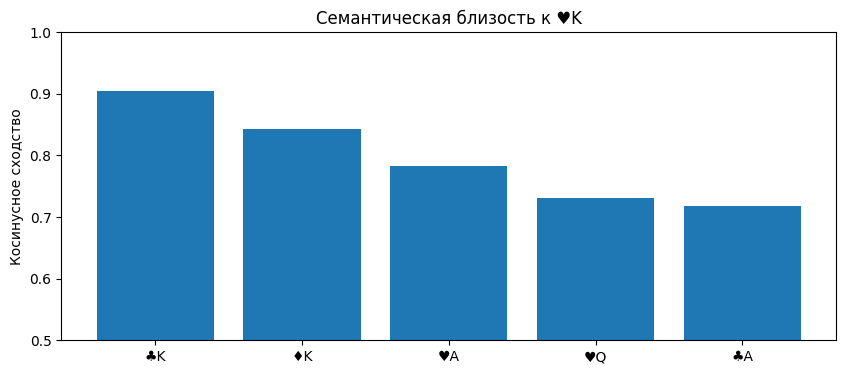


Карты, похожие на ♠7:
♣7: сходство = 0.8832
♦7: сходство = 0.7768
♠8: сходство = 0.7290
♠6: сходство = 0.7064
♥7: сходство = 0.6854


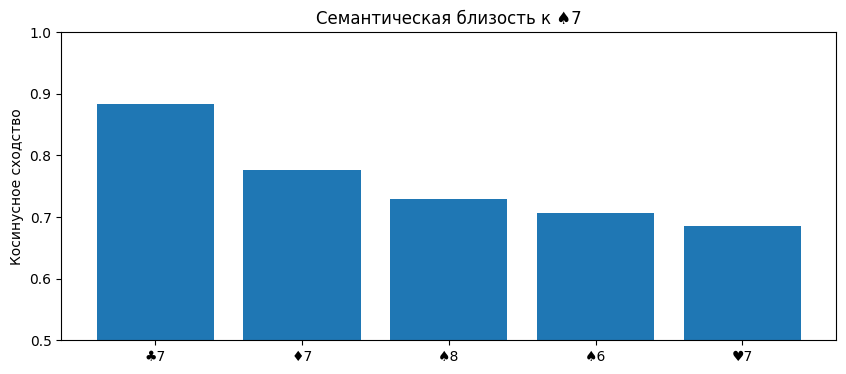

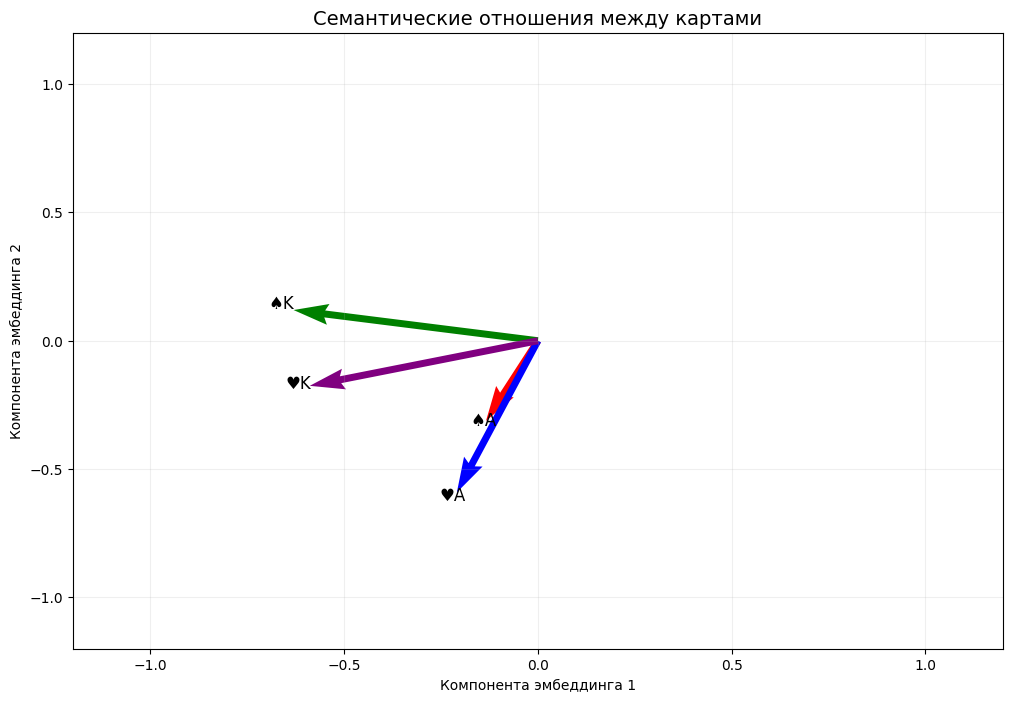

In [117]:
# 1. Извлечение эмбеддингов для всех карт
model.eval()
embeddings = {}
with torch.no_grad():
    for suit in range(4):
        for rank in range(13):
            suit_tensor = torch.tensor([suit])
            rank_tensor = torch.tensor([rank])
            emb = model.get_embedding(suit_tensor, rank_tensor)
            card_name = f"{['♠','♥','♦','♣'][suit]}{['2','3','4','5','6','7','8','9','10','J','Q','K','A'][rank]}"
            embeddings[card_name] = emb.numpy().flatten()

embedding_matrix = np.array(list(embeddings.values()))
labels = list(embeddings.keys())

# 3. Функция поиска ближайших соседей
def find_similar_cards(query_card, top_k=5):
    query_embed = embeddings[query_card].reshape(1, -1)
    similarities = cosine_similarity(query_embed, embedding_matrix)[0]

    # Исключаем саму карту из результатов
    similar_indices = np.argsort(similarities)[-top_k-1:-1][::-1]

    print(f"\nКарты, похожие на {query_card}:")
    for idx in similar_indices:
        print(f"{labels[idx]}: сходство = {similarities[idx]:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 4))
    plt.bar([labels[i] for i in similar_indices], similarities[similar_indices])
    plt.title(f"Семантическая близость к {query_card}")
    plt.ylabel("Косинусное сходство")
    plt.ylim(0.5, 1.0)
    plt.show()

# Примеры использования
find_similar_cards("♥K")  # Король червей
find_similar_cards("♠7")  # Семерка пик

# 4. Визуализация отношений между картами
def plot_card_relations(cards):
    plt.figure(figsize=(12, 8))

    # Извлечение эмбеддингов для выбранных карт
    vectors = [embeddings[card] for card in cards]

    # Нормализация для визуализации
    vectors = np.array(vectors)
    vectors /= np.linalg.norm(vectors, axis=1)[:, np.newaxis]

    # Построение векторов
    origin = np.zeros((len(cards), 2))
    plt.quiver(origin[:, 0], origin[:, 1],
               vectors[:, 0], vectors[:, 1],
               angles='xy', scale_units='xy', scale=1,
               color=['red', 'blue', 'green', 'purple'])

    # Подписи
    for i, card in enumerate(cards):
        plt.text(vectors[i, 0]*1.05, vectors[i, 1]*1.05,
                 card, fontsize=12, ha='center')

    # Настройки графика
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.grid(alpha=0.2)
    plt.title("Семантические отношения между картами", fontsize=14)
    plt.xlabel("Компонента эмбеддинга 1")
    plt.ylabel("Компонента эмбеддинга 2")
    plt.show()

# Пример визуализации отношений
plot_card_relations(["♠A", "♥A", "♠K", "♥K"])  # Туз и король пик/червей


Карты, похожие на вектор ♥K:
♥K: сходство = 0.9842
♦K: сходство = 0.9019
♣K: сходство = 0.8641
♥A: сходство = 0.7791
♠K: сходство = 0.7446
♥Q: сходство = 0.7268


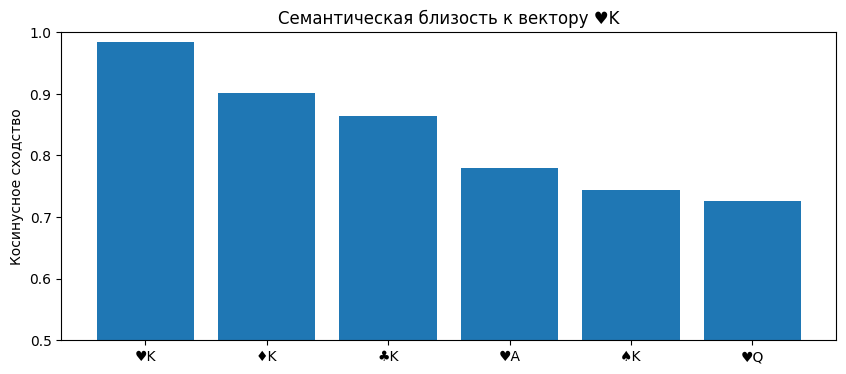

In [119]:
def find_similar_cards_vector(vector, semantic_nearest, top_k=5):
    query_embed = vector.reshape(1, -1)
    similarities = cosine_similarity(query_embed, embedding_matrix)[0]

    # Исключаем саму карту из результатов
    similar_indices = np.argsort(similarities)[-top_k-1:][::-1]

    print(f"\nКарты, похожие на вектор {semantic_nearest}:")
    for idx in similar_indices:
        print(f"{labels[idx]}: сходство = {similarities[idx]:.4f}")

    # Визуализация
    plt.figure(figsize=(10, 4))
    plt.bar([labels[i] for i in similar_indices], similarities[similar_indices])
    plt.title(f"Семантическая близость к вектору {semantic_nearest}")
    plt.ylabel("Косинусное сходство")
    plt.ylim(0.5, 1.0)
    plt.show()

king_vector = embeddings["♠K"] - embeddings["♠Q"]
queen_vector = embeddings["♥Q"] + king_vector
find_similar_cards_vector(queen_vector, "♥K")


Карты, похожие на вектор ♠Q:
♠Q: сходство = 0.9842
♦Q: сходство = 0.8671
♣Q: сходство = 0.8125
♠J: сходство = 0.7580
♠K: сходство = 0.7333
♥Q: сходство = 0.7161


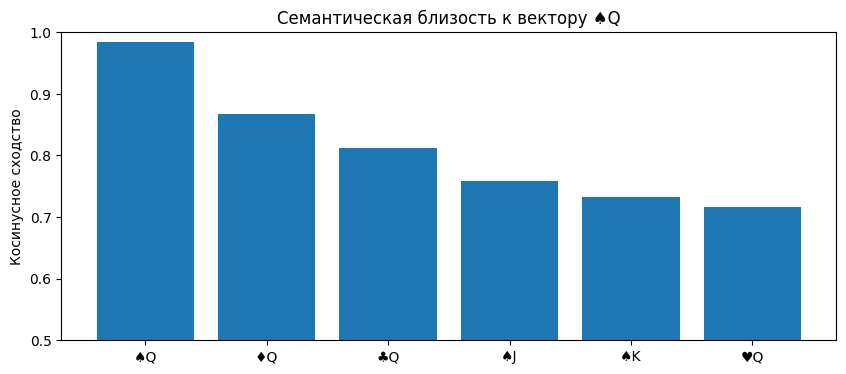

In [120]:
spade_to_heart_vector = embeddings["♠K"] - embeddings["♥K"]
queen_vector = embeddings["♥Q"] + spade_to_heart_vector
find_similar_cards_vector(queen_vector, "♠Q")